In [ ]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm.auto import tqdm
import torchmetrics
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from utils import target_loss 
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

In [ ]:
#dataload
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform_30/train/'
test_csv_path ='../../data/AF/Waveform_30/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,750)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,750)
test_label=torch.empty(len(test_data_list),1)
for i in tqdm(range(len(train_data_list))):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(resized(signal_csv,750))
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in tqdm(range(len(test_data_list))):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(resized(signal_csv,750))
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
class SciNet(nn.Module):
	def __init__(self, input_dim, output_dim, latent_dim, layer_dim):
		super(SciNet, self).__init__()
		self.latent_dim = latent_dim
		self.enc1 = nn.Linear(input_dim, layer_dim)
		self.enc2 = nn.Linear(layer_dim, layer_dim)
		self.latent = nn.Linear(layer_dim, latent_dim*2)
		self.dec1 = nn.Linear(latent_dim+1, layer_dim)
		self.dec2 = nn.Linear(layer_dim,layer_dim)
		self.out = nn.Linear(layer_dim, output_dim)       
	  
	def encoder(self, x):
		z = F.relu(self.enc1(x))
		z = F.relu(self.enc2(z))
		z = self.latent(z)
		self.mu = z[:, 0:self.latent_dim]
		self.log_sigma = z[:, self.latent_dim:]
		self.sigma = torch.exp(self.log_sigma)        

		# Use reparametrization trick to sample from gaussian
		eps = torch.randn(x.size(0), self.latent_dim)
		z_sample = self.mu + self.sigma * eps.to(device0)        

		# Compute KL loss
		self.kl_loss = kl_divergence(self.mu, self.log_sigma, dim=self.latent_dim)

		return z_sample
	
	def decoder(self, z):
		x = F.relu(self.dec1(z))
		x = F.relu(self.dec2(x))        
		return self.out(x)

	def forward(self, obs):
     
		obs=obs.squeeze()
		q = obs[:,-1].reshape(obs.size(0),1)
		self.latent_r = self.encoder(obs) 
		dec_input = torch.cat((q, self.latent_r), 1)

		return self.decoder(dec_input)


def kl_divergence(means, log_sigma, dim, target_sigma=0.1):
	"""
	Computes Kullback–Leibler divergence for arrays of mean and log(sigma)
	"""
	target_sigma = torch.Tensor([target_sigma]).to(device0)
	return 1 / 2. * torch.mean(torch.mean(1 / target_sigma**2 * means**2 +
			torch.exp(2 * log_sigma) / target_sigma**2 - 2 * log_sigma + 2 * torch.log(target_sigma), dim=1) - dim)

    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = SciNet(750, 1, 3,64).to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
summary(model,[(batch_size,1,750)])

Layer (type:depth-idx)                   Output Shape              Param #
SciNet                                   [256, 1]                  --
├─Linear: 1-1                            [256, 64]                 48,064
├─Linear: 1-2                            [256, 64]                 4,160
├─Linear: 1-3                            [256, 6]                  390
├─Linear: 1-4                            [256, 64]                 320
├─Linear: 1-5                            [256, 64]                 4,160
├─Linear: 1-6                            [256, 1]                  65
Total params: 57,159
Trainable params: 57,159
Non-trainable params: 0
Total mult-adds (M): 14.63
Input size (MB): 0.77
Forward/backward pass size (MB): 0.54
Params size (MB): 0.23
Estimated Total Size (MB): 1.54

In [ ]:
# Training setup
SAVE_PATH = "model/scinet1.dat"
N_EPOCHS = 100
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):

        inputs, outputs = minibatch
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
    
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

epoch: 1/1000 train_loss : 0.6938 train_accuracy: 0.4956 val_loss : 0.6936  val_accuracy: 0.5063
epoch: 2/1000 train_loss : 0.6928 train_accuracy: 0.5129 val_loss : 0.6949  val_accuracy: 0.4746


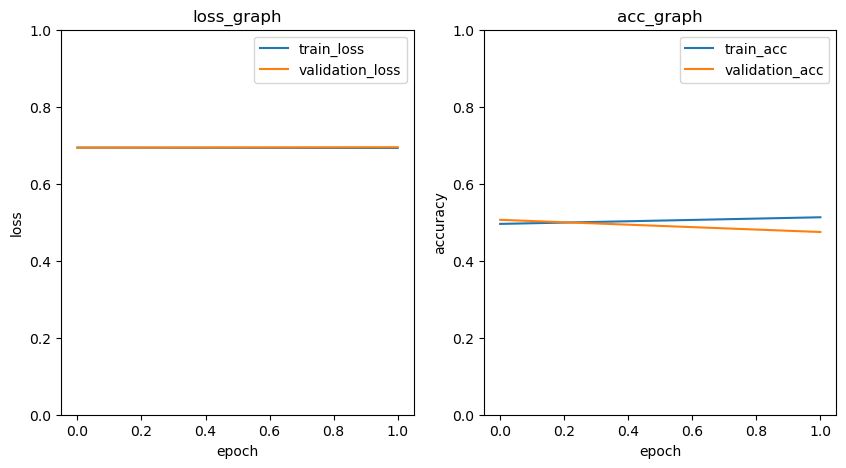

epoch: 3/1000 train_loss : 0.6926 train_accuracy: 0.5143 val_loss : 0.6964  val_accuracy: 0.4500
epoch: 4/1000 train_loss : 0.6928 train_accuracy: 0.5146 val_loss : 0.6976  val_accuracy: 0.4422
epoch: 5/1000 train_loss : 0.6922 train_accuracy: 0.5219 val_loss : 0.6979  val_accuracy: 0.4449
epoch: 6/1000 train_loss : 0.6923 train_accuracy: 0.5205 val_loss : 0.6984  val_accuracy: 0.4371
epoch: 7/1000 train_loss : 0.6923 train_accuracy: 0.5209 val_loss : 0.6994  val_accuracy: 0.4383
epoch: 8/1000 train_loss : 0.6924 train_accuracy: 0.5206 val_loss : 0.6991  val_accuracy: 0.4359
epoch: 9/1000 train_loss : 0.6923 train_accuracy: 0.5207 val_loss : 0.6994  val_accuracy: 0.4340
epoch: 10/1000 train_loss : 0.6922 train_accuracy: 0.5211 val_loss : 0.6995  val_accuracy: 0.4410
epoch: 11/1000 train_loss : 0.6922 train_accuracy: 0.5204 val_loss : 0.6994  val_accuracy: 0.4387
epoch: 12/1000 train_loss : 0.6922 train_accuracy: 0.5224 val_loss : 0.7000  val_accuracy: 0.4340
epoch: 13/1000 train_loss :

KeyboardInterrupt: 

In [16]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/SciNet_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/SciNet.pt')